In [39]:
import dask
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats

In [ ]:
# Open ERA5 data from Google Cloud
ds = xr.open_zarr(
    "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3",
    chunks={"time": 48},
    storage_options=dict(token="anon"),
)

ds = ds.sel(time=slice(ds.attrs["valid_time_start"], ds.attrs["valid_time_stop"]))

ds

<xarray.Dataset> Size: 2PB
Dimensions:                                                          (
                                                                      time: 748008,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * latitude                                                         (latitude) float32 3kB ...
  * level                                                            (level) int64 296B ...
  * longitude                                                        (longitude) float32 6kB ...
  * time                                                             (time) datetime64[ns] 6MB ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 3TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 3TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 3TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 3TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 3TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 3TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 3TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 3TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 3TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 3TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    wave_spectral_skewness                                           (time, latitude, longitude) float32 3TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    zero_degree_level                                                (time, latitude, longitude) float32 3TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
Attributes:
    last_updated:           2025-09-22 01:57:27.339380+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-04-30
    valid_time_stop_era5t:  2025-09-16

In [ ]:
# Select Total Precipitation variable and resample data to daily.
daily_sfctp = ds["total_precipitation"].resample(time="D").sum()

daily_sfctp

<xarray.DataArray 'total_precipitation' (time: 31167, latitude: 721,
                                         longitude: 1440)> Size: 129GB
dask.array<stack, shape=(31167, 721, 1440), dtype=float32, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 249kB 1940-01-01 1940-01-02 ... 2025-04-30
Attributes:
    long_name:   Total precipitation
    short_name:  tp
    units:       m

In [ ]:
# Select daily total precipitation data from a 5° x 5° box around Asheville, NC (35.5975° N, 82.5461° W)
# from 2015 to 2025.
lat1 = 35.6 + 2.5
lat2 = 35.6 - 2.5
lon1 = 360 - 82.5 - 2.5
lon2 = 360 - 82.5 + 2.5

daily_sfctp_avl = daily_sfctp.sel(
    latitude=slice(lat1, lat2),
    longitude=slice(lon1, lon2),
    time=slice("2015-04-30", "2025-04-30"),
)

daily_sfctp_avl = daily_sfctp_avl.persist()

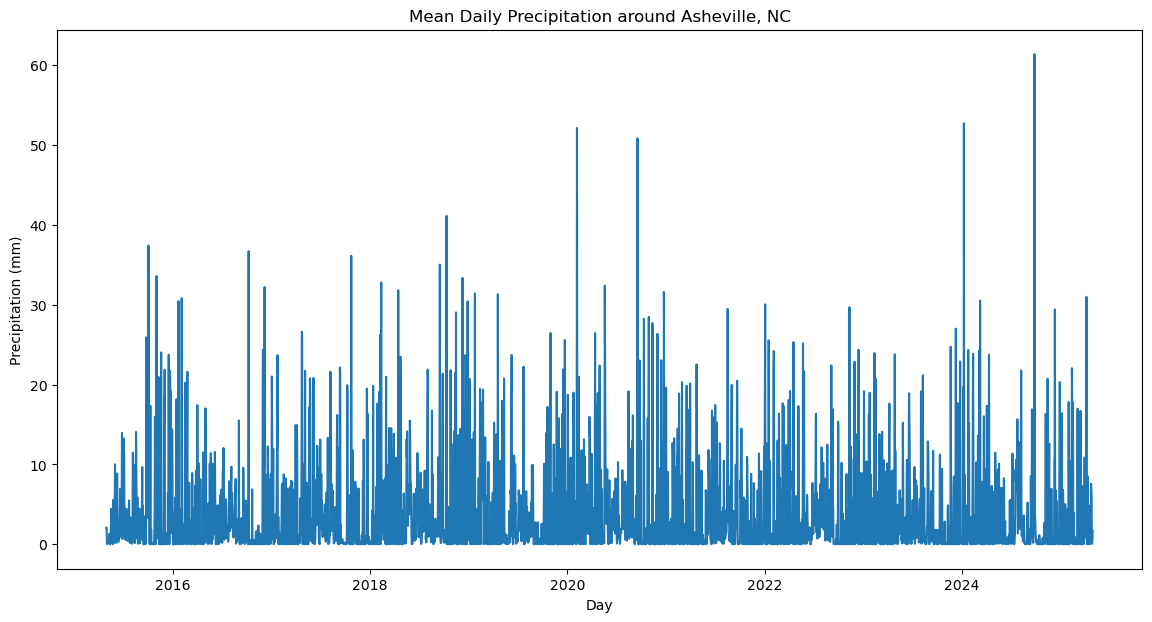

In [49]:
# Take mean over lat and lon to get Mean Total Daily Precipitation and convert to mm.
daily_sfctp_avlavgmm = (
    daily_sfctp_avl.mean(dim=["latitude", "longitude"]).compute() * 1000
)

# Plot time-series of Mean Total Daily Precipitation
fig, ax = plt.subplots(figsize=(14, 7))
cs = ax.plot(daily_sfctp_avl["time"], daily_sfctp_avlavgmm)
ax.set_title("Mean Daily Precipitation around Asheville, NC")
ax.set_xlabel("Day")
ax.set_ylabel("Precipitation (mm)")
plt.show()

In [ ]:
# Get 95th percentile value of daily precipitation
q95 = daily_sfctp_avlavgmm.quantile(0.95, dim="time")

q95

<xarray.DataArray 'total_precipitation' ()> Size: 8B
array(16.03820524)
Coordinates:
    quantile  float64 8B 0.95

In [25]:
# Get days where the daily total precipitation is in the 95th percentile.
daily_sfctp_avl_95 = daily_sfctp_avlavgmm.where(daily_sfctp_avlavgmm >= q95, drop=True)

daily_sfctp_avl_95.time

<xarray.DataArray 'time' (time: 183)> Size: 1kB
array(['2015-09-25T00:00:00.000000000', '2015-09-29T00:00:00.000000000',
       '2015-10-03T00:00:00.000000000', '2015-10-04T00:00:00.000000000',
       '2015-10-10T00:00:00.000000000', '2015-11-02T00:00:00.000000000',
       '2015-11-09T00:00:00.000000000', '2015-11-19T00:00:00.000000000',
       '2015-11-30T00:00:00.000000000', '2015-12-02T00:00:00.000000000',
       '2015-12-17T00:00:00.000000000', '2015-12-22T00:00:00.000000000',
       '2015-12-24T00:00:00.000000000', '2015-12-25T00:00:00.000000000',
       '2016-01-15T00:00:00.000000000', '2016-01-22T00:00:00.000000000',
       '2016-02-03T00:00:00.000000000', '2016-02-16T00:00:00.000000000',
       '2016-02-24T00:00:00.000000000', '2016-04-01T00:00:00.000000000',
       '2016-05-01T00:00:00.000000000', '2016-10-08T00:00:00.000000000',
       '2016-11-29T00:00:00.000000000', '2016-11-30T00:00:00.000000000',
       '2016-12-06T00:00:00.000000000', '2017-01-02T00:00:00.000000000',
       '2017-01-23T00:00:00.000000000', '2017-04-23T00:00:00.000000000',
       '2017-04-24T00:00:00.000000000', '2017-05-05T00:00:00.000000000',
       '2017-05-21T00:00:00.000000000', '2017-05-23T00:00:00.000000000',
       '2017-05-24T00:00:00.000000000', '2017-06-05T00:00:00.000000000',
       '2017-08-07T00:00:00.000000000', '2017-09-01T00:00:00.000000000',
       '2017-09-11T00:00:00.000000000', '2017-09-12T00:00:00.000000000',
       '2017-10-08T00:00:00.000000000', '2017-10-09T00:00:00.000000000',
       '2017-10-23T00:00:00.000000000', '2017-12-20T00:00:00.000000000',
       '2017-12-23T00:00:00.000000000', '2018-01-12T00:00:00.000000000',
       '2018-01-28T00:00:00.000000000', '2018-02-04T00:00:00.000000000',
       '2018-02-07T00:00:00.000000000', '2018-02-11T00:00:00.000000000',
       '2018-03-01T00:00:00.000000000', '2018-04-15T00:00:00.000000000',
       '2018-04-23T00:00:00.000000000', '2018-04-24T00:00:00.000000000',
       '2018-08-01T00:00:00.000000000', '2018-08-02T00:00:00.000000000',
       '2018-08-03T00:00:00.000000000', '2018-08-18T00:00:00.000000000',
       '2018-09-16T00:00:00.000000000', '2018-09-17T00:00:00.000000000',
       '2018-09-27T00:00:00.000000000', '2018-10-11T00:00:00.000000000',
       '2018-10-26T00:00:00.000000000', '2018-11-12T00:00:00.000000000',
       '2018-11-15T00:00:00.000000000', '2018-12-09T00:00:00.000000000',
       '2018-12-14T00:00:00.000000000', '2018-12-20T00:00:00.000000000',
       '2018-12-21T00:00:00.000000000', '2018-12-28T00:00:00.000000000',
       '2019-01-04T00:00:00.000000000', '2019-01-24T00:00:00.000000000',
       '2019-02-12T00:00:00.000000000', '2019-02-20T00:00:00.000000000',
       '2019-02-23T00:00:00.000000000', '2019-04-19T00:00:00.000000000',
       '2019-05-05T00:00:00.000000000', '2019-05-12T00:00:00.000000000',
       '2019-06-07T00:00:00.000000000', '2019-06-08T00:00:00.000000000',
       '2019-06-09T00:00:00.000000000', '2019-07-23T00:00:00.000000000',
       '2019-10-20T00:00:00.000000000', '2019-10-30T00:00:00.000000000',
       '2019-10-31T00:00:00.000000000', '2019-11-23T00:00:00.000000000',
       '2019-12-13T00:00:00.000000000', '2019-12-17T00:00:00.000000000',
       '2019-12-23T00:00:00.000000000', '2020-01-03T00:00:00.000000000',
       '2020-01-24T00:00:00.000000000', '2020-02-06T00:00:00.000000000',
       '2020-02-07T00:00:00.000000000', '2020-02-11T00:00:00.000000000',
       '2020-02-13T00:00:00.000000000', '2020-04-13T00:00:00.000000000',
       '2020-04-20T00:00:00.000000000', '2020-04-23T00:00:00.000000000',
       '2020-04-30T00:00:00.000000000', '2020-05-19T00:00:00.000000000',
       '2020-05-20T00:00:00.000000000', '2020-08-15T00:00:00.000000000',
       '2020-08-31T00:00:00.000000000', '2020-09-17T00:00:00.000000000',
       '2020-09-25T00:00:00.000000000', '2020-10-11T00:00:00.000000000',
       '2020-10-29T00:00:00.000000000', '2020-11-11T00:00:00.000000000',
       '2020-11-12T00:00:00.000000000', '2020-11-30T00:00:00.000000000',
       '20

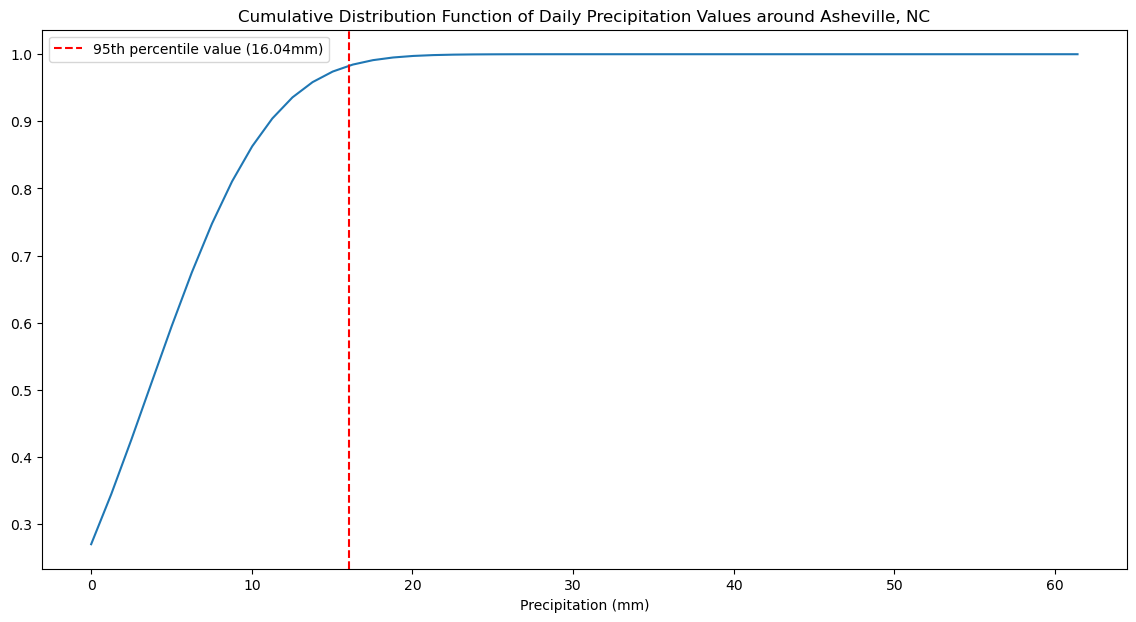

In [63]:
# Plot Cumulative Distribution Function of daily precipitation values around Asheville, NC
fig, ax = plt.subplots(figsize=(14, 7))

mu, std = stats.norm.fit(daily_sfctp_avlavgmm.values.flatten())
x = np.linspace(daily_sfctp_avlavgmm.min(), daily_sfctp_avlavgmm.max())
cdf = stats.norm.cdf(x, loc=mu, scale=std)

ax.plot(x, cdf)
ax.axvline(q95, color="r", linestyle="--", label="95th percentile value (16.04mm)")
ax.set_title(
    "Cumulative Distribution Function of Daily Precipitation Values around Asheville, NC"
)
ax.set_xlabel("Precipitation (mm)")
plt.legend()
plt.show()

In [ ]:
# Get global daily precipitation on days where daily total precipitation
# is in the 95th percentile in the Asheville, NC and convert to mm.
daily_sfctp_95 = (
    daily_sfctp.sel(time=daily_sfctp_avl_95.time).mean(dim="time").compute()
)

daily_sfctp_95mm = daily_sfctp_95 * 1000
daily_sfctp_95mm

<xarray.DataArray 'total_precipitation' (latitude: 721, longitude: 1440)> Size: 4MB
array([[0.67730284, 0.67730284, 0.67730284, ..., 0.67730284, 0.67730284,
        0.67730284],
       [0.6729822 , 0.67299545, 0.67300314, ..., 0.67283714, 0.67290276,
        0.6729536 ],
       [0.65934926, 0.6593747 , 0.65942824, ..., 0.6593277 , 0.6594669 ,
        0.65946096],
       ...,
       [0.17655626, 0.17657329, 0.17656702, ..., 0.17654575, 0.17655803,
        0.176563  ],
       [0.17126133, 0.17116371, 0.17114958, ..., 0.17121108, 0.17120448,
        0.17122391],
       [0.1865061 , 0.1865061 , 0.1865061 , ..., 0.1865061 , 0.1865061 ,
        0.1865061 ]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    quantile   float64 8B 0.95

In [ ]:
# Get the 1981-2010 daily total precipitation mean and convert to mm.
daily_sfctp_1981_2010 = (
    daily_sfctp.sel(time=slice("1981-01-01", "2010-12-31")).mean(dim=["time"]).compute()
)

daily_sfctp_1981_2010 = daily_sfctp_1981_2010 * 1000

daily_sfctp_1981_2010

<xarray.DataArray 'total_precipitation' (latitude: 721, longitude: 1440)> Size: 4MB
array([[0.6998418 , 0.6998418 , 0.6998418 , ..., 0.6998418 , 0.6998418 ,
        0.6998418 ],
       [0.7070862 , 0.7070888 , 0.70710695, ..., 0.70700604, 0.70701766,
        0.7070342 ],
       [0.6978474 , 0.69790673, 0.6979504 , ..., 0.69766146, 0.69769555,
        0.69774246],
       ...,
       [0.17811626, 0.17810033, 0.17807356, ..., 0.17810853, 0.17811646,
        0.17812091],
       [0.17806347, 0.17798144, 0.17798018, ..., 0.17811169, 0.17810425,
        0.17809777],
       [0.19077408, 0.19077408, 0.19077408, ..., 0.19077408, 0.19077408,
        0.19077408]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8

In [ ]:
# Calculate anomalies of composite mean precipitation on the 95th percentile days compared to the 1981-2010 mean.
daily_sfctp_anom = daily_sfctp_95mm - daily_sfctp_1981_2010

In [ ]:
# Save lat and lon coordinates
lat = daily_sfctp_95mm["latitude"]
lon = daily_sfctp_95mm["longitude"]

/Users/joshokrend/anaconda3/lib/python3.11/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/joshokrend/anaconda3/lib/python3.11/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


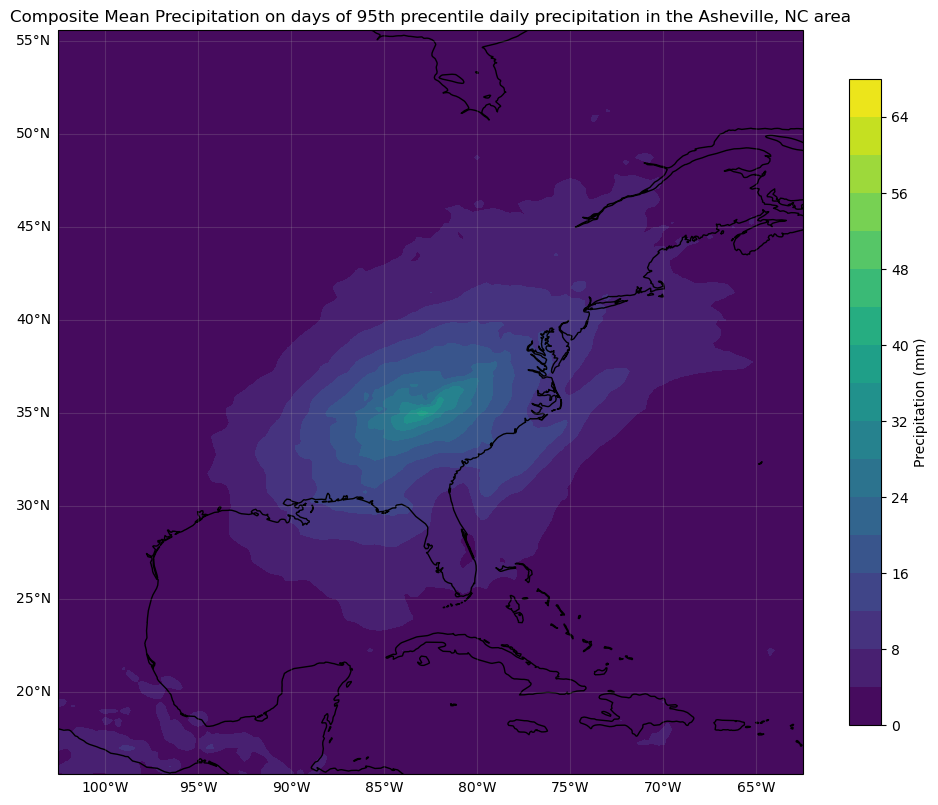

In [42]:
# Plot the composite mean precipitation on the 95th percentile days over the continental USA.
lat1 = 35.6 - 20
lat2 = 35.6 + 20
lon1 = 360 - 82.5 - 20
lon2 = 360 - 82.5 + 20

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection=ccrs.PlateCarree()))

X, Y = np.meshgrid(lon, lat)
cs = ax.contourf(X, Y, daily_sfctp_95mm, levels=20, transform=ccrs.PlateCarree())
cb = fig.colorbar(cs, shrink=0.7)
ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, alpha=0.2)
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
ax.set_title(
    "Composite Mean Precipitation on days of 95th precentile daily precipitation in the Asheville, NC area"
)
cb.set_label("Precipitation (mm)")
plt.show()

/Users/joshokrend/anaconda3/lib/python3.11/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/joshokrend/anaconda3/lib/python3.11/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


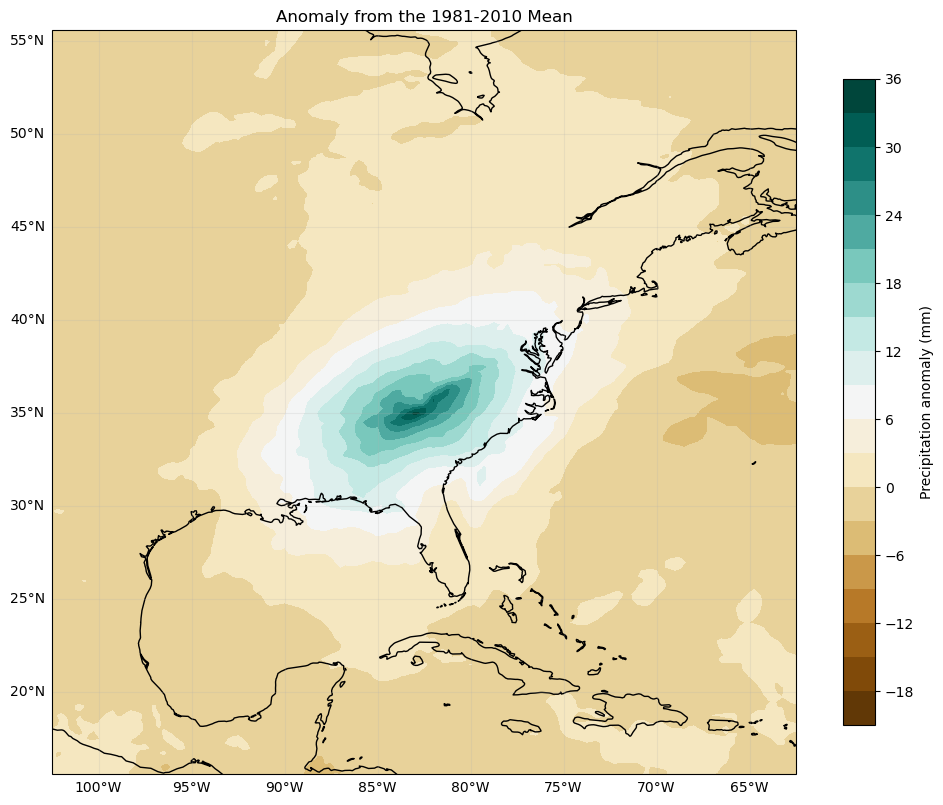

In [ ]:
# Plot the composite mean precipitation anomalies on the 95th percentile days over the continental USA.
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection=ccrs.PlateCarree()))

X, Y = np.meshgrid(lon, lat)
cs = ax.contourf(
    X, Y, daily_sfctp_anom, cmap="BrBG", levels=20, transform=ccrs.PlateCarree()
)
cb = fig.colorbar(cs, shrink=0.7)
ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, alpha=0.2)
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
ax.set_title("Anomaly from the 1981-2010 Mean")
cb.set_label("Precipitation anomaly (mm)")
plt.show()